# Perhitungan Skor RNN-IDS

## Import All Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import math

## Load All the Data

In [2]:
df_pred = pd.read_csv('/home/apta/neuralnetwork-AD/rnn-apta/results/vector/Combine_Control_Tuesday-WorkingHours_training_80/result-lstm-tcp80-hl2-seq5-do0.2-oov1500-Thursday-WorkingHours_testing_80.csv', 
                      names=['id', 'binary_error', 'b_mean', 'b_iqr', 'b_zscore', 'floatin_error', 'f_mean', 'f_iqr', 'f_zscore'])

df_truth = pd.read_csv('/home/apta/CIC-IDS-2017/CSVs/TrafficLabelling/Thursday-WorkingHours.pcap_ISCX.csv', 
                       encoding='ISO-8859-1')


/tmp/ipykernel_363639/4038963619.py:4: DtypeWarning: Columns (0,1,3,6,84) have mixed types. Specify dtype option on import or set low_memory=False.
  df_truth = pd.read_csv('/home/apta/CIC-IDS-2017/CSVs/TrafficLabelling/Thursday-WorkingHours.pcap_ISCX.csv',


In [3]:
df_pred.head()

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore
0,192.168.10.15-49439-131.253.61.98-80-tcp,0.095082,0,0,1,29920.920000,0,0,0
1,192.168.10.15-49442-23.60.139.27-80-tcp,0.064935,0,0,1,13639.030973,0,0,0
2,192.168.10.15-49441-23.63.226.146-80-tcp,0.091873,0,0,1,37030.762590,0,0,0
3,192.168.10.15-49448-23.15.4.16-80-tcp,0.095973,0,0,1,18746.609428,0,0,0
4,192.168.10.14-59146-72.21.91.29-80-tcp,0.030588,0,0,1,16925.861905,0,0,0


In [4]:
df_truth.head()

,Flow ID,Source IP,Source Port,Destination IP,Destination Port,Protocol,Timestamp,Flow Duration,Total Fwd Packets,Total Backward Packets,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,192.168.10.12-192.168.10.50-60148-22-6,192.168.10.12,60148.0,192.168.10.50,22.0,6.0,6/7/2017 1:00,166.0,1.0,1.0,...,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
1,192.168.10.12-192.168.10.50-60148-22-6,192.168.10.50,22.0,192.168.10.12,60148.0,6.0,6/7/2017 1:00,83.0,1.0,2.0,...,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
2,192.168.10.12-91.189.89.199-123-123-17,192.168.10.12,123.0,91.189.89.199,123.0,17.0,6/7/2017 1:00,99947.0,1.0,1.0,...,40.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
3,192.168.10.12-72.38.129.202-123-123-17,192.168.10.12,123.0,72.38.129.202,123.0,17.0,6/7/2017 1:00,37017.0,1.0,1.0,...,32.0,0.000,0.000,0.0,0.0,0.0,0.000,0.0,0.0,BENIGN
4,8.0.6.4-8.6.0.1-0-0-0,8.6.0.1,0.0,8.0.6.4,0.0,0.0,6/7/2017 1:00,111161336.0,147.0,0.0,...,0.0,1753752.625,2123197.578,4822992.0,95.0,9463032.7,2657727.996,13600000.0,5700287.0,BENIGN


## Exploratory Data Analysis

In [5]:
df_truth[[' Label']].value_counts()

 Label                     
BENIGN                         456752
Web Attack Â Brute Force        1507
Web Attack Â XSS                 652
Infiltration                       36
Web Attack Â Sql Injection        21
Name: count, dtype: int64

In [6]:
df_pred[['b_iqr']].value_counts()

b_iqr
0        25832
Name: count, dtype: int64

In [7]:
df_pred[['b_zscore']].value_counts()

b_zscore
1           25811
0              21
Name: count, dtype: int64

In [8]:
df_truth.isnull().sum()

Flow ID              288602
 Source IP           288602
 Source Port         288602
 Destination IP      288602
 Destination Port    288602
                      ...  
Idle Mean            288602
 Idle Std            288602
 Idle Max            288602
 Idle Min            288602
 Label               288602
Length: 85, dtype: int64

## Data Pre-Processing

### Convert the type of the data

In [9]:
df_truth.columns = df_truth.columns.str.strip()  # remove leading/trailing spaces
df_truth.columns = df_truth.columns.str.replace(' ', '_')  # optional: make them easier to type

df_truth['Source_Port'] = pd.to_numeric(df_truth['Source_Port'], errors='coerce')
df_truth['Destination_Port'] = pd.to_numeric(df_truth['Destination_Port'], errors='coerce')

# Optionally: drop rows with NaN in these columns
df_truth.dropna(subset=['Source_Port', 'Destination_Port'], inplace=True)

# Filter to only include rows where either port is 80
df_truth = df_truth[(df_truth['Source_Port'] == 80) | (df_truth['Destination_Port'] == 80)]

# Now you can safely convert to int
df_truth['Source_Port'] = df_truth['Source_Port'].astype(int)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(int)


df_truth.info()

<class 'pandas.core.frame.DataFrame'>
Index: 63887 entries, 9 to 458958
Data columns (total 85 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Flow_ID                      63887 non-null  object 
 1   Source_IP                    63887 non-null  object 
 2   Source_Port                  63887 non-null  int64  
 3   Destination_IP               63887 non-null  object 
 4   Destination_Port             63887 non-null  int64  
 5   Protocol                     63887 non-null  float64
 6   Timestamp                    63887 non-null  object 
 7   Flow_Duration                63887 non-null  float64
 8   Total_Fwd_Packets            63887 non-null  float64
 9   Total_Backward_Packets       63887 non-null  float64
 10  Total_Length_of_Fwd_Packets  63887 non-null  float64
 11  Total_Length_of_Bwd_Packets  63887 non-null  float64
 12  Fwd_Packet_Length_Max        63887 non-null  float64
 13  Fwd_Packet_Length_Mi

In [10]:
df_truth['Label'].head()

9     BENIGN
10    BENIGN
39    BENIGN
40    BENIGN
41    BENIGN
Name: Label, dtype: object

In [11]:
df_truth['Source_Port'] = df_truth['Source_Port'].astype(str)
df_truth['Destination_Port'] = df_truth['Destination_Port'].astype(str)

df_truth['Protocol'] = pd.to_numeric(df_truth['Protocol'], errors='coerce')  
df_truth.dropna(subset=['Protocol'], inplace=True)                      
df_truth['Protocol'] = df_truth['Protocol'].astype(int).astype(str)         

protocol_map = {
    '6': 'tcp',
    '17': 'udp',
    '1': 'icmp',
    '0': 'other'  # fallback or unknown
}

# Convert 'Protocol' number to string using the mapping
def map_protocol(protocol):
    return protocol_map.get(protocol, 'other')

# Apply the conversion for 'Protocol' and concatenate the 'id'
df_truth['id'] = df_truth[['Source_IP', 'Source_Port', 'Destination_IP', 'Destination_Port', 'Protocol']]\
    .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)

/tmp/ipykernel_363639/691346611.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  .astype(str).apply(lambda row: "-".join([row[0], row[1], row[2], row[3], map_protocol(row[4])]), axis=1)


## Making Predictions

In [12]:
df_pred["id"]

0         192.168.10.15-49439-131.253.61.98-80-tcp
1          192.168.10.15-49442-23.60.139.27-80-tcp
2         192.168.10.15-49441-23.63.226.146-80-tcp
3            192.168.10.15-49448-23.15.4.16-80-tcp
4           192.168.10.14-59146-72.21.91.29-80-tcp
                           ...                    
25827     192.168.10.14-52024-40.112.213.22-80-tcp
25828    192.168.10.51-44532-211.233.74.132-80-tcp
25829    192.168.10.51-44538-211.233.74.132-80-tcp
25830    192.168.10.51-44547-211.233.74.132-80-tcp
25831    192.168.10.51-44554-211.233.74.132-80-tcp
Name: id, Length: 25832, dtype: object

In [13]:
df_truth["id"]

9         192.168.10.15-55578-172.217.10.142-80-tcp
10        192.168.10.15-55581-172.217.10.142-80-tcp
39           72.21.91.29-80-192.168.10.15-55543-tcp
40           72.21.91.29-80-192.168.10.15-55480-tcp
41         23.210.202.27-80-192.168.10.15-55449-tcp
                            ...                    
458940      52.84.40.136-80-192.168.10.15-55570-tcp
458941      52.84.40.136-80-192.168.10.15-55571-tcp
458953       192.168.10.15-55480-72.21.91.29-80-tcp
458957       192.168.10.15-55543-72.21.91.29-80-tcp
458958       192.168.10.15-55544-72.21.91.29-80-tcp
Name: id, Length: 63887, dtype: object

In [14]:
# Convert 'Label' column to numeric: BENIGN -> 0, other -> 1
df_truth['Label'] = df_truth['Label'].apply(lambda x: 0 if x == 'BENIGN' else 1)

In [15]:
# df_pred["Label"] = np.where(df_pred["id"].isin(df_truth["id"]), 1, 0)

df_pred = df_pred.merge(df_truth[['id', 'Label']], on='id', how='left')
df_pred = df_pred.dropna(subset=['Label'])

In [16]:
df_pred[df_pred['Label']==1]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
1783,172.16.0.1-44380-192.168.10.50-80-tcp,0.118861,0,0,1,31843.110563,0,0,0,1
1784,172.16.0.1-44380-192.168.10.50-80-tcp,0.118861,0,0,1,31843.110563,0,0,0,1
1785,172.16.0.1-44382-192.168.10.50-80-tcp,0.127049,0,0,1,40841.469051,0,0,0,1
1786,172.16.0.1-44384-192.168.10.50-80-tcp,0.093264,0,0,1,28377.169792,0,0,0,1
1787,172.16.0.1-44386-192.168.10.50-80-tcp,0.093911,0,0,1,28461.386929,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...
15241,172.16.0.1-49362-192.168.10.50-80-tcp,0.160432,0,0,1,42287.241235,0,0,0,1
15402,172.16.0.1-49502-192.168.10.50-80-tcp,0.169231,0,0,1,49402.170690,0,0,0,1
15403,172.16.0.1-49502-192.168.10.50-80-tcp,0.169231,0,0,1,49402.170690,0,0,0,1
15406,172.16.0.1-49522-192.168.10.50-80-tcp,0.150769,0,0,1,48002.203125,0,0,0,1


In [17]:
df_pred[df_pred['Label']==0]

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.15-49439-131.253.61.98-80-tcp,0.095082,0,0,1,29920.920000,0,0,0,0
1,192.168.10.15-49439-131.253.61.98-80-tcp,0.095082,0,0,1,29920.920000,0,0,0,0
2,192.168.10.15-49442-23.60.139.27-80-tcp,0.064935,0,0,1,13639.030973,0,0,0,0
3,192.168.10.15-49442-23.60.139.27-80-tcp,0.064935,0,0,1,13639.030973,0,0,0,0
4,192.168.10.15-49441-23.63.226.146-80-tcp,0.091873,0,0,1,37030.762590,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
47328,192.168.10.51-44538-211.233.74.132-80-tcp,0.042254,0,0,1,31425.833333,0,0,0,0
47329,192.168.10.51-44547-211.233.74.132-80-tcp,0.042254,0,0,1,31425.833333,0,0,0,0
47330,192.168.10.51-44547-211.233.74.132-80-tcp,0.042254,0,0,1,31425.833333,0,0,0,0
47331,192.168.10.51-44554-211.233.74.132-80-tcp,0.042254,0,0,1,31425.833333,0,0,0,0


In [18]:
df_pred

,id,binary_error,b_mean,b_iqr,b_zscore,floatin_error,f_mean,f_iqr,f_zscore,Label
0,192.168.10.15-49439-131.253.61.98-80-tcp,0.095082,0,0,1,29920.920000,0,0,0,0
1,192.168.10.15-49439-131.253.61.98-80-tcp,0.095082,0,0,1,29920.920000,0,0,0,0
2,192.168.10.15-49442-23.60.139.27-80-tcp,0.064935,0,0,1,13639.030973,0,0,0,0
3,192.168.10.15-49442-23.60.139.27-80-tcp,0.064935,0,0,1,13639.030973,0,0,0,0
4,192.168.10.15-49441-23.63.226.146-80-tcp,0.091873,0,0,1,37030.762590,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
47328,192.168.10.51-44538-211.233.74.132-80-tcp,0.042254,0,0,1,31425.833333,0,0,0,0
47329,192.168.10.51-44547-211.233.74.132-80-tcp,0.042254,0,0,1,31425.833333,0,0,0,0
47330,192.168.10.51-44547-211.233.74.132-80-tcp,0.042254,0,0,1,31425.833333,0,0,0,0
47331,192.168.10.51-44554-211.233.74.132-80-tcp,0.042254,0,0,1,31425.833333,0,0,0,0


In [19]:
df_pred[['Label']].value_counts()

Label
0        46948
1          385
Name: count, dtype: int64

In [20]:
import os
# Define the directory path
dir_path = '../mcnemar/http'

# Check if the directory exists, and if not, create it
if not os.path.exists(dir_path):
    os.makedirs(dir_path)

df_temp = df_pred[['id', 'b_mean','b_iqr', 'b_zscore', 'f_zscore', 'f_mean','f_iqr' ]]
df_temp.to_csv(os.path.join(dir_path, 'pred_0.0.csv'))

## Calculating Score

In [21]:
threshold = ['b_mean', 'b_iqr', 'b_zscore']
threshold_2 = ['f_mean', 'f_iqr', 'f_zscore']

methods = ['binary', 'floating']

In [22]:
df_pred[['b_zscore']]

,b_zscore
0,1
1,1
2,1
3,1
4,1
...,...
47328,1
47329,1
47330,1
47331,1


### Detection Rate

In [23]:
from sklearn.metrics import recall_score

score = dict()
score['Detection Rate'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = recall_score(df_pred['Label'], df_pred[i])
            score['Detection Rate'][i] = acc
            print(f'Recall-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = recall_score(df_pred['Label'], df_pred[i])
            score['Detection Rate'][i] = acc
            print(f'Recall-Floating-{i}: {acc}')  

Recall-Binary-b_mean: 0.0
Recall-Binary-b_iqr: 0.0
Recall-Binary-b_zscore: 1.0
Recall-Floating-f_mean: 0.0
Recall-Floating-f_iqr: 0.0
Recall-Floating-f_zscore: 0.0


### Confussion Matrix

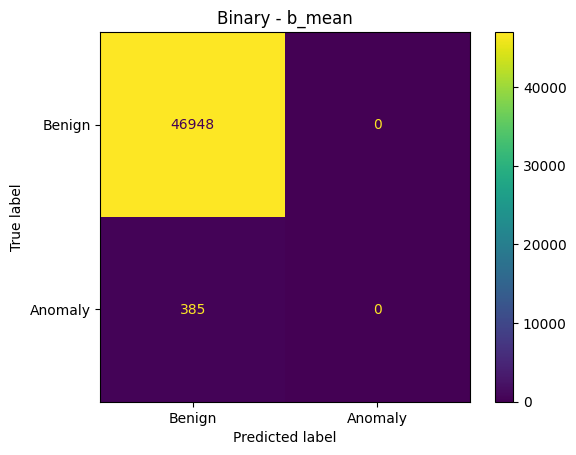

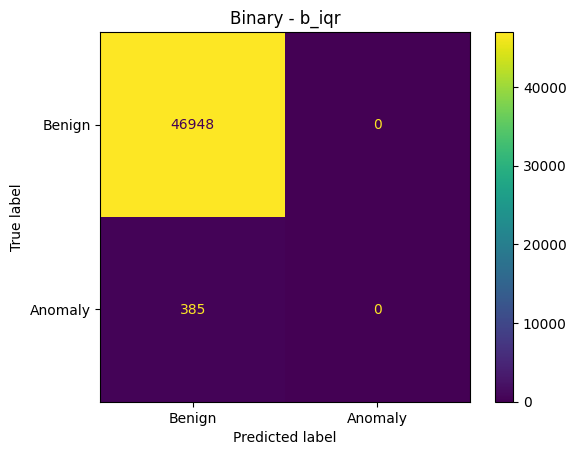

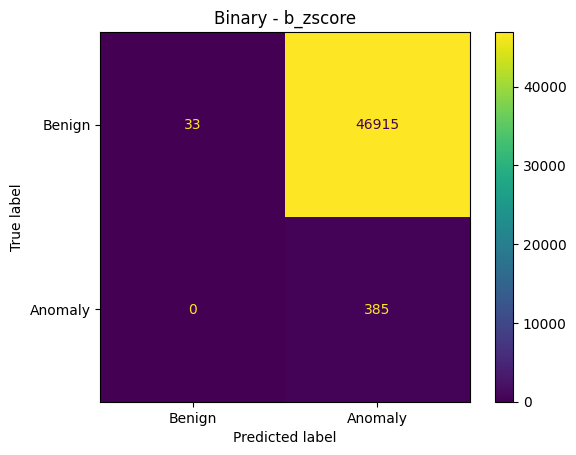

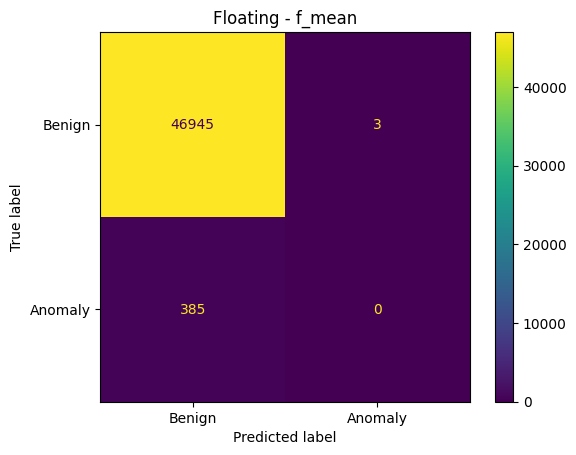

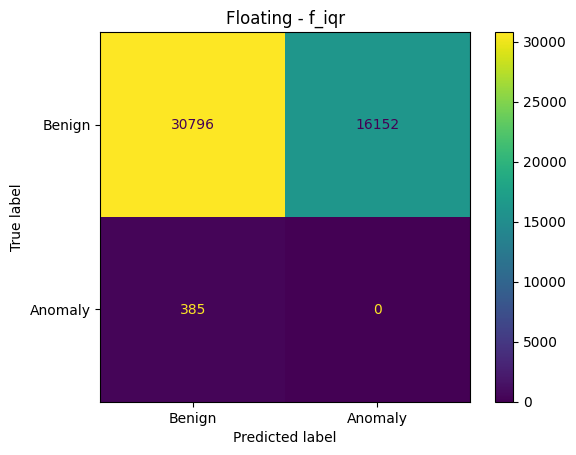

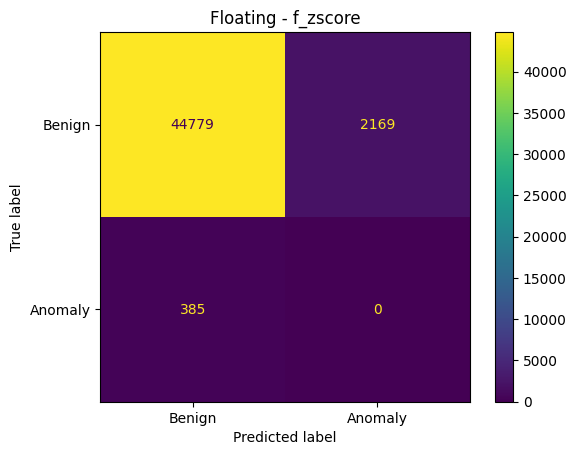

In [24]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

for method in methods:
    if method == 'binary':
        for i in threshold:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i])
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Binary - {i.strip()}')
            plt.show()
    else:
        for i in threshold_2:
            conf_matrix = confusion_matrix(df_pred['Label'], df_pred[i])
            cm_display = ConfusionMatrixDisplay(confusion_matrix = conf_matrix, display_labels=['Benign', 'Anomaly'])
            cm_display.plot()
            plt.title(f'Floating - {i.strip()}')
            plt.show()


### F2-Score

In [25]:
score['F2 Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Binary-{i}: {f2}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            f2 = ((1+2**2)*tp)/((1+2**2)*tp+2**2*fn+fp)
            score['F2 Score'][i] = f2
            print(f'F2-Floating-{i}: {f2}')

F2-Binary-b_mean: 0.0
F2-Binary-b_iqr: 0.0
F2-Binary-b_zscore: 0.039414414414414414
F2-Floating-f_mean: 0.0
F2-Floating-f_iqr: 0.0
F2-Floating-f_zscore: 0.0


### FPR Score

In [26]:
score['FPR Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Binary-{i}: {fpr}')
    else:
        for i in threshold_2:
            tn, fp, fn, tp = confusion_matrix(df_pred['Label'], df_pred[i]).ravel()
            fpr = fp/(fp+tn)
            score['FPR Score'][i] = fpr
            print(f'FPR-Floating-{i}: {fpr}')

FPR-Binary-b_mean: 0.0
FPR-Binary-b_iqr: 0.0
FPR-Binary-b_zscore: 0.9992970946579194
FPR-Floating-f_mean: 6.390048564369089e-05
FPR-Floating-f_iqr: 0.3440402147056318
FPR-Floating-f_zscore: 0.04620005112038852


In [27]:
from sklearn.metrics import accuracy_score

score['Accuracy Score'] = dict()
for method in methods:
    if method == 'binary':
        for i in threshold:
            acc = accuracy_score(df_pred['Label'], df_pred[i])
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Binary-{i}: {acc}')
    else:
        for i in threshold_2:
            acc = accuracy_score(df_pred['Label'], df_pred[i])
            score['Accuracy Score'][i] = acc
            print(f'Accuracy-Floating-{i}: {acc}')  

Accuracy-Binary-b_mean: 0.9918661399023937
Accuracy-Binary-b_iqr: 0.9918661399023937
Accuracy-Binary-b_zscore: 0.008831048105972577
Accuracy-Floating-f_mean: 0.9918027591743603
Accuracy-Floating-f_iqr: 0.6506243001711279
Accuracy-Floating-f_zscore: 0.9460418735343207


In [28]:
df_score = pd.DataFrame.from_dict(score)
df_score

,Detection Rate,F2 Score,FPR Score,Accuracy Score
b_mean,0.0,0.000000,0.000000,0.991866
b_iqr,0.0,0.000000,0.000000,0.991866
b_zscore,1.0,0.039414,0.999297,0.008831
f_mean,0.0,0.000000,0.000064,0.991803
f_iqr,0.0,0.000000,0.344040,0.650624
f_zscore,0.0,0.000000,0.046200,0.946042


In [29]:
df_score.to_excel('score_ftp_0.0.xlsx')

In [30]:
# %pip install openpyxl